<a href="https://colab.research.google.com/github/oleksandragolub/Calcolatrice-Scientifica-in-java/blob/main/assignment3_aml_oleksandra_golub_856706_finale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Advanced Machine Learning (Assignment 3)**
---
---

Università degli Studi Milano Bicocca \
CdLM Informatica — A.A 2025/2026

---
---

#### **Componenti del gruppo:**
— Oleksandra Golub (856706)




In [ ]:
# STEP: caricamento di librerie
!pip install kagglehub

import kagglehub
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from sklearn.metrics import confusion_matrix

# Set seed per riproducibilità, rende deterministica la casualità di NumPy
np.random.seed(42)

print("Librerie importate con successo!")

Librerie importate con successo!


In [ ]:
# per Google Colab
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cpu


In [ ]:
# STEP: definizione della CNN compatta (rete progettata per rimanere sotto il limite di 7000 parametri)
class CompactCNN(nn.Module):
    def __init__(self):
        super(CompactCNN, self).__init__()

        # primo blocco convoluzionale
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)  # 1*8*3*3 + 8 = 80 params
        self.bn1 = nn.BatchNorm2d(8)  # 16 params (8*2)

        # secondo blocco convoluzionale con stride per ridurre dimensioni
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1)  # 8*16*3*3 + 16 = 1168 params
        self.bn2 = nn.BatchNorm2d(16)  # 32 params

        # terzo blocco convoluzionale
        self.conv3 = nn.Conv2d(16, 24, kernel_size=3, stride=2, padding=1)  # 16*24*3*3 + 24 = 3480 params
        self.bn3 = nn.BatchNorm2d(24)  # 48 params

        # global average pooling per ridurre parametri
        self.global_pool = nn.AdaptiveAvgPool2d(1)

        # fully connected layers
        self.fc1 = nn.Linear(24, 32)  # 24*32 + 32 = 800 params
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(32, 10)  # 32*10 + 10 = 330 params

        # Totale: 80 + 16 + 1168 + 32 + 3480 + 48 + 800 + 330 = 5954 parametri

    def forward(self, x): # descrive il percorso dei dati attraverso i layer
        # primo blocco (rileva bordi, texture semplici)
        x = F.relu(self.bn1(self.conv1(x)))

        # secondo blocco (compone forme più complesse)
        x = F.relu(self.bn2(self.conv2(x)))

        # terzo blocco (riconosce parti significative dei numeri)
        x = F.relu(self.bn3(self.conv3(x)))

        # global average pooling (riduce ogni feature map a un singolo valore, abbassando il numero di parametri e prevenendo l’overfitting)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)

        # fully connected layers (usano feature di prima per prendere la decisione finale e classificare l’immagine in una delle 10 classi MNIST)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

    def count_parameters(self): # calcola il numero totale di parametri addestrabili
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [ ]:
# STEP: funzione per contare e visualizzare i parametri
def analyze_model(model):
    print("Analisi del modello:")
    print("-" * 50)
    total_params = 0

    for name, param in model.named_parameters():
        if param.requires_grad:
            num_params = param.numel() # conta quanti parametri contiene ogni layer
            total_params += num_params  # somma il totale dei parametri addestrabili
            print(f"{name:30} | Shape: {str(param.shape):20} | Params: {num_params:,}")

    print("-" * 50)
    print(f"TOTALE PARAMETRI ADDESTRABILI: {total_params:,}")

    if total_params > 7000:
        print(f"ATTENZIONE: il modello supera il limite di 7000 parametri!")
    else:
        print(f"OK: il modello rispetta il limite ({7000 - total_params:,} parametri rimanenti)")

    return total_params

# Creiamo e analizziamo il modello
model = CompactCNN().to(device)
total_params = analyze_model(model)

Analisi del modello:
--------------------------------------------------
conv1.weight                   | Shape: torch.Size([8, 1, 3, 3]) | Params: 72
conv1.bias                     | Shape: torch.Size([8])      | Params: 8
bn1.weight                     | Shape: torch.Size([8])      | Params: 8
bn1.bias                       | Shape: torch.Size([8])      | Params: 8
conv2.weight                   | Shape: torch.Size([16, 8, 3, 3]) | Params: 1,152
conv2.bias                     | Shape: torch.Size([16])     | Params: 16
bn2.weight                     | Shape: torch.Size([16])     | Params: 16
bn2.bias                       | Shape: torch.Size([16])     | Params: 16
conv3.weight                   | Shape: torch.Size([24, 16, 3, 3]) | Params: 3,456
conv3.bias                     | Shape: torch.Size([24])     | Params: 24
bn3.weight                     | Shape: torch.Size([24])     | Params: 24
bn3.bias                       | Shape: torch.Size([24])     | Params: 24
fc1.weight            

In [ ]:
# STEP: preparazione del dataset MNIST
def prepare_data(batch_size=64):
    # trasformazioni con data augmentation leggera
    transform_train = transforms.Compose([
        transforms.RandomRotation(5),  # rotazione leggera casuale
        transforms.ToTensor(), # converte le immagini in tensori PyTorch
        transforms.Normalize((0.1307,), (0.3081,))  # normalizza usando media e std del dataset MNIST
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    # download e caricamento dataset
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform_train)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform_test)

    # dataLoaders creati per l'uso futuro del modello
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

train_loader, test_loader = prepare_data()
print(f"Training samples: {len(train_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 358kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.19MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.36MB/s]

Training samples: 60000
Test samples: 10000


In [ ]:
# STEP: funzioni di training e valutazione
def train_epoch(model, device, train_loader, optimizer, criterion, epoch):
    model.train()   # si imposta il modello nella modalita' addestramento
    train_loss = 0  # inizializzato accumulatore di perdita'
    correct = 0     # inizializzato accumulatore di correttezza

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)   # dove data sono immagini e target sono etichette

        optimizer.zero_grad()    # si azzerano i gradienti precedenti
        output = model(data)     # si esegue il forward pass
        loss = criterion(output, target) # si calcola la perdita'
        loss.backward()          # si fa il backward pass per il calcolo del gradiente
        optimizer.step()         # si aggiornano i pesi della rete

        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    avg_loss = train_loss / len(train_loader)
    accuracy = 100. * correct / len(train_loader.dataset)

    return avg_loss, accuracy

def evaluate(model, device, test_loader, criterion): # serve per misurare le performance del modello dopo ogni epoch e alla fine dell’addestramento
    model.eval() # si imposta il modello nella modalita' di valutazione
    test_loss = 0
    correct = 0

    with torch.no_grad():   # si disabilita il calcolo dei gradienti
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)

    print(f'\nTest set: Average loss: {test_loss:.4f}, '
          f'Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')

    return test_loss, accuracy

In [ ]:
# STEP: Training completo con learning rate scheduling
def train_model(model, train_loader, test_loader, epochs=20):
    criterion = nn.CrossEntropyLoss()   # CrossEntropyLoss() per la classificazione a 10 classi
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)   # weight_decay per ridurre overfitting

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',     # riduce automaticamente il learning rate quando la test loss non migliora per 3 epoch
                                                      factor=0.5, patience=3)

    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []

    best_acc = 0

    for epoch in range(1, epochs + 1):
        print(f"\n{'='*60}")
        print(f"EPOCH {epoch}/{epochs}")
        print(f"{'='*60}")

        # training
        train_loss, train_acc = train_epoch(model, device, train_loader,
                                           optimizer, criterion, epoch)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # evaluation
        test_loss, test_acc = evaluate(model, device, test_loader, criterion)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        # ;earning rate scheduling
        scheduler.step(test_loss)

        # stampa il learning rate corrente
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Current Learning Rate: {current_lr:.6f}")

        # stampa il miglior modello
        if test_acc > best_acc:
            best_acc = test_acc
            print(f"Nuovo miglior modello salvato! Accuracy: {test_acc:.2f}%")

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

    return train_losses, train_accs, test_losses, test_accs, best_acc

In [ ]:
# STEP: avviamo il training
print("Iniziando il training...")
train_losses, train_accs, test_losses, test_accs, best_acc = train_model(
    model, train_loader, test_loader, epochs=20
)

Iniziando il training...

EPOCH 1/20
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.295887
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.095142
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.766235
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.354748
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.358060
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.197042
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.204669
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.996477
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.881348
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.730294

Test set: Average loss: 0.7182, Accuracy: 7652/10000 (76.52%)

Current Learning Rate: 0.001000
Nuovo miglior modello salvato! Accuracy: 76.52%
Train Loss: 1.3300, Train Acc: 51.80%
Test Loss: 0.7182, Test Acc: 76.52%

EPOCH 2/20
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.948736
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.808499
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.692944
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.900318
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.86

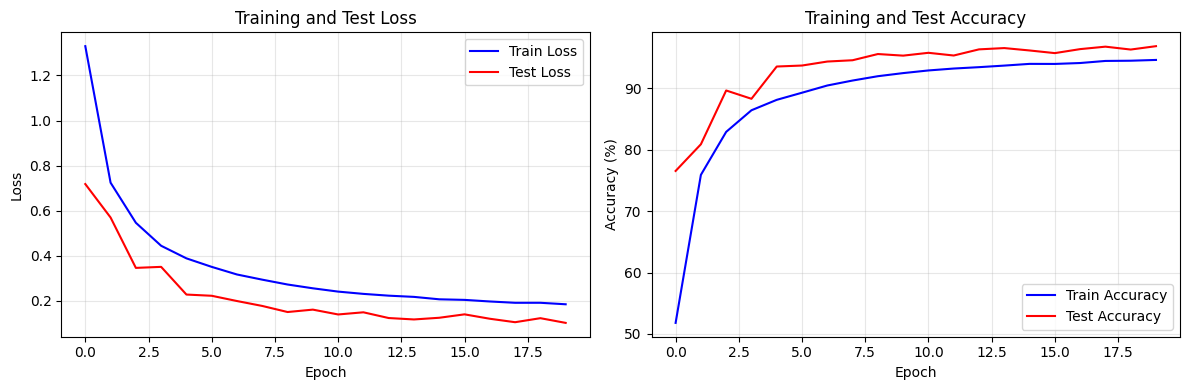


Miglior accuracy sul test set: 96.82%


In [ ]:
# STEP: visualizzazione dei risultati
def plot_training_history(train_losses, train_accs, test_losses, test_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # loss plot
    ax1.plot(train_losses, label='Train Loss', color='blue')
    ax1.plot(test_losses, label='Test Loss', color='red')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Test Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # accuracy plot
    ax2.plot(train_accs, label='Train Accuracy', color='blue')
    ax2.plot(test_accs, label='Test Accuracy', color='red')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Test Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training_history(train_losses, train_accs, test_losses, test_accs)
print(f"\nMiglior accuracy sul test set: {best_acc:.2f}%")

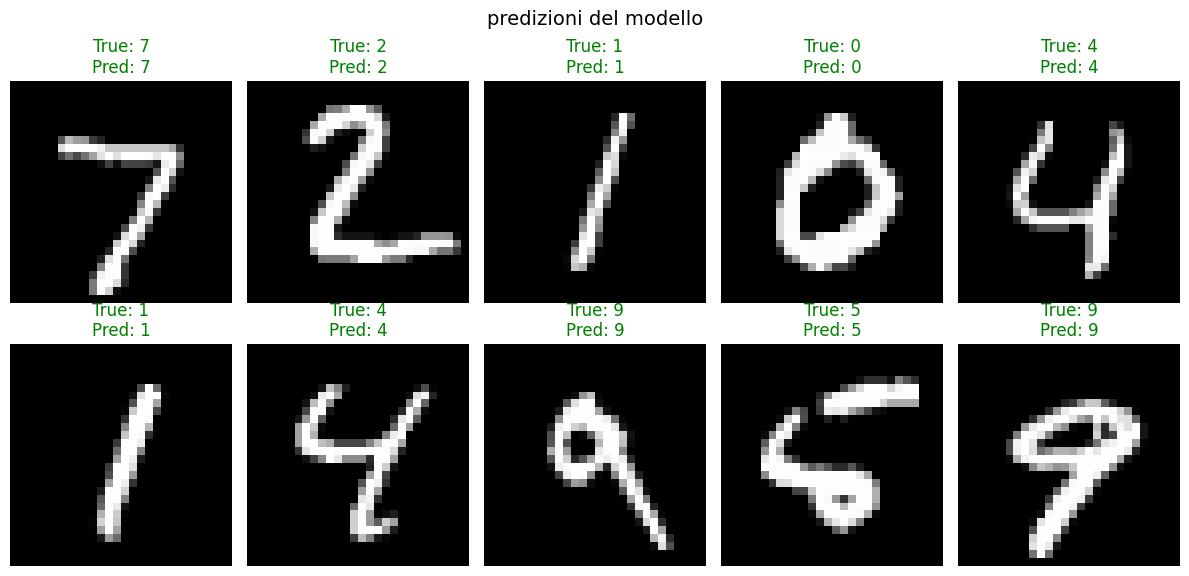

In [ ]:
# STEP: visualizzazione di alcune predizioni
# seleziona alcune immagini del test set, calcola le predizioni del modello e visualizza una griglia di risultati, evidenziando in verde le classificazioni corrette e in rosso quelle errate
# serve per capire quanto bene predice i risultati il modello
def visualize_predictions(model, test_loader, num_images=10):
    model.eval()

    # si prende un batch dal test loader
    data, target = next(iter(test_loader))
    data, target = data[:num_images].to(device), target[:num_images].to(device)

    with torch.no_grad():
        output = model(data)
        pred = output.argmax(dim=1)

    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    axes = axes.flatten()

    for i in range(num_images):
        img = data[i].cpu().numpy().squeeze()
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'True: {target[i].item()}\nPred: {pred[i].item()}',
                         color='green' if target[i] == pred[i] else 'red')
        axes[i].axis('off')

    plt.suptitle('predizioni del modello', fontsize=14)
    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_loader)

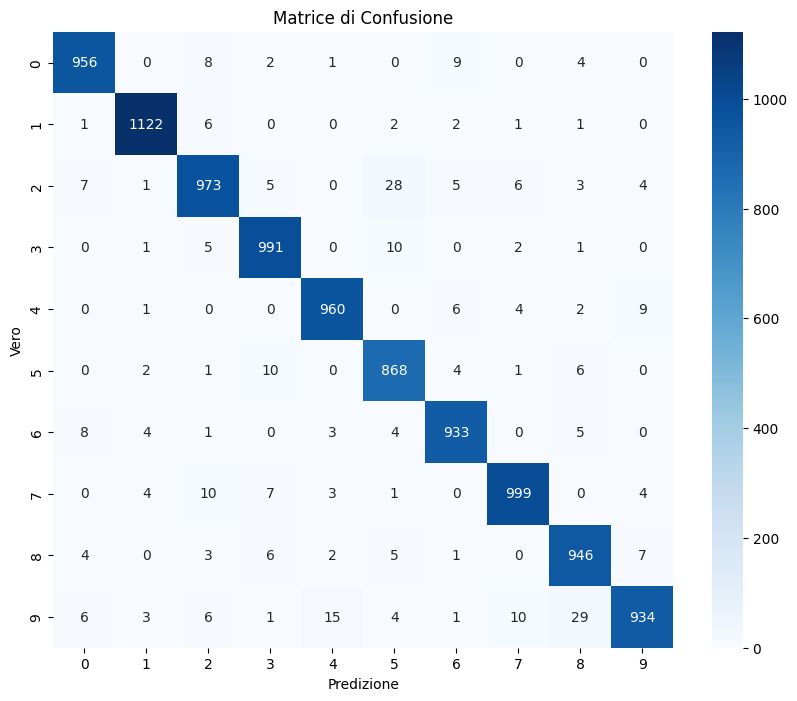

Classe 0: 97.55% accuracy
Classe 1: 98.85% accuracy
Classe 2: 94.28% accuracy
Classe 3: 98.12% accuracy
Classe 4: 97.76% accuracy
Classe 5: 97.31% accuracy
Classe 6: 97.39% accuracy
Classe 7: 97.18% accuracy
Classe 8: 97.13% accuracy
Classe 9: 92.57% accuracy


In [ ]:
# STEP: analisi degli errori e matrice di confusione
from sklearn.metrics import confusion_matrix
import seaborn as sns

def analyze_errors(model, test_loader):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    # matrice di confusione
    cm = confusion_matrix(all_targets, all_preds)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=range(10), yticklabels=range(10))
    plt.title('Matrice di Confusione')
    plt.xlabel('Predizione')
    plt.ylabel('Vero')
    plt.show()

    # si calcola l'accuracy per classe
    class_acc = cm.diagonal() / cm.sum(axis=1)
    for i in range(10):
        print(f"Classe {i}: {class_acc[i]*100:.2f}% accuracy")

    return cm

cm = analyze_errors(model, test_loader)